# Imports

In [1]:
# data manipulation 
import numpy as np
import pandas as pd

from datetime import datetime
from sklearn import metrics

from sklearn.metrics import mean_squared_error
from math import sqrt
import statsmodels.api as sm

# data visualization 
import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
%matplotlib inline

#modeling
from statsmodels.tsa.api import Holt

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

import acquire1
import prepare1


Using tore_item_sales

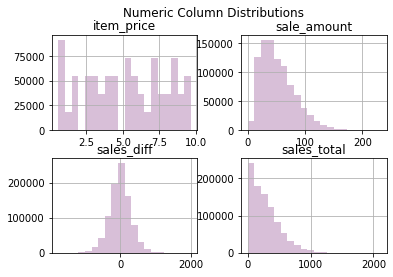

In [2]:
store = prepare1.prepped_store_df()

In [3]:
store.head(2)

,sale_amount,sale_id,store_address,store_city,store_id,store_state,store_zipcode,item_brand,item_id,item_name,item_price,item_upc12,item_upc14,month,weekday,sales_total,sales_diff
sale_date,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00+00:00,13.0,1,12125 Alamo Ranch Pkwy,San Antonio,1,TX,78253,Riceland,1,Riceland American Jazmine Rice,0.84,35200264013,35200264013,1,Tuesday,10.92,NaN
2013-01-01 00:00:00+00:00,26.0,211817,12018 Perrin Beitel Rd,San Antonio,7,TX,78217,Mueller,12,Mueller Sport Care Basic Support Level Medium ...,8.40,74676640211,74676640211,1,Tuesday,218.40,207.48


In [4]:
df = store[["sale_amount", "sales_total"]]

In [5]:
df.rename(columns={"sale_amount": "items_sold"}, inplace=True)

1. Split data (train/test) and resample by any period, except daily, and aggregate using the sum.

In [6]:
train_size = int(len(df) * .5)
val_size = int(len(df) * .3)
test_size = int(len(df) - train_size - val_size)

In [7]:
print(train_size)
print(val_size)
print(test_size)
print(train_size + val_size)

456500
273900
182600
730400


In [8]:
val_end_index = train_size + val_size
val_end_index

730400

In [9]:
train = df[:train_size]
validate = df[train_size : val_end_index]
test = df[val_end_index:]

In [10]:
train.head()

,items_sold,sales_total
sale_date,,
2013-01-01 00:00:00+00:00,13.0,10.92
2013-01-01 00:00:00+00:00,26.0,218.40
2013-01-01 00:00:00+00:00,27.0,125.55
2013-01-01 00:00:00+00:00,54.0,453.60
2013-01-01 00:00:00+00:00,35.0,294.00


In [11]:
train.shape

(456500, 2)

In [12]:
validate.head()

,items_sold,sales_total
sale_date,,
2015-07-03 00:00:00+00:00,31.0,186.31
2015-07-03 00:00:00+00:00,105.0,544.95
2015-07-03 00:00:00+00:00,80.0,314.40
2015-07-03 00:00:00+00:00,53.0,61.48
2015-07-03 00:00:00+00:00,47.0,28.20


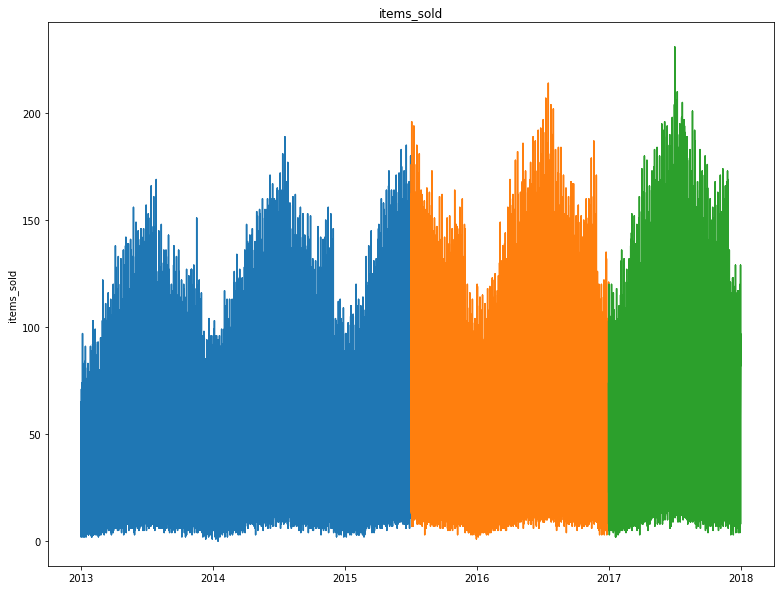

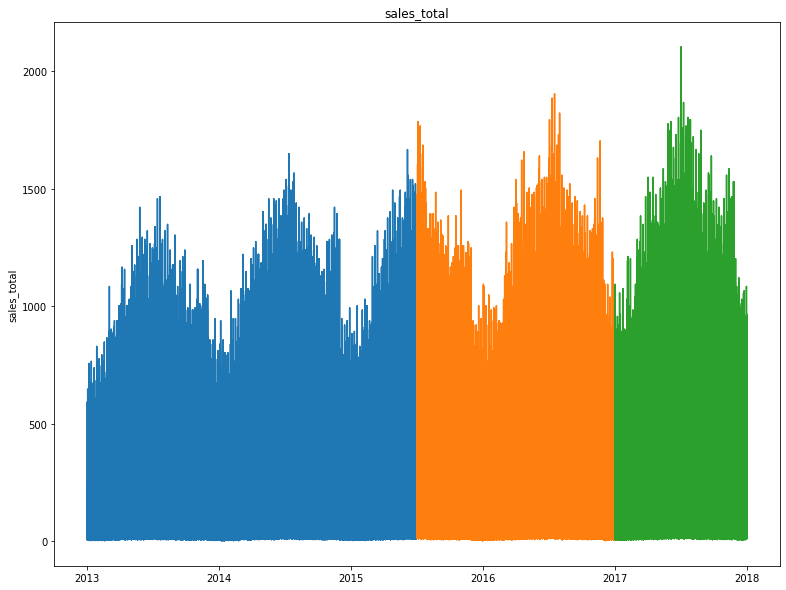

In [13]:
#Validate splits
for col in train.columns:
    plt.figure(figsize=(13,10))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show


In [14]:
df = df.resample("W").sum()
train = train.resample("W").sum()
validate = validate.resample("W").sum()
test = test.resample("W").sum()

2. Forecast, plot and evaluate using each of the 4 parametric based methods we discussed:
- Simple Average
- Moving Average
- Holt's Linear Trend Model
- Based on previous year/month/etc., this is up to you.

# Simple Average

In [15]:
items = round(train["items_sold"].mean(), 2)
dollars = round(train["sales_total"].mean(), 2)

In [16]:
def make_predictions():
    yhat_df = pd.DataFrame({"items_sold": [items],
                           "sales_total": [dollars]},
                          index = validate.index)
    return yhat_df

In [17]:
yhat_df = make_predictions()

In [18]:
yhat_df

,items_sold,sales_total
sale_date,,
2015-07-05 00:00:00+00:00,165373.25,889116.94
2015-07-12 00:00:00+00:00,165373.25,889116.94
2015-07-19 00:00:00+00:00,165373.25,889116.94
2015-07-26 00:00:00+00:00,165373.25,889116.94
2015-08-02 00:00:00+00:00,165373.25,889116.94
...,...,...
2016-12-04 00:00:00+00:00,165373.25,889116.94
2016-12-11 00:00:00+00:00,165373.25,889116.94
2016-12-18 00:00:00+00:00,165373.25,889116.94


## Plot Actual VS Predicted

In [19]:
def evaluate_rmse(target_var):
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [20]:
def plot_and_evaluate(target_variable):
    plt.figure(figsize=(13,10))
    plt.plot(train[target_variable], label = "Train", linewidth = 1)
    plt.plot(validate[target_variable], label = "Validate", linewidth = 1)
    plt.plot(yhat_df[target_variable])
    plt.title(target_variable)
    rmse = evaluate_rmse(target_variable)
    print(target_variable, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()
    

items_sold -- RMSE: 45484


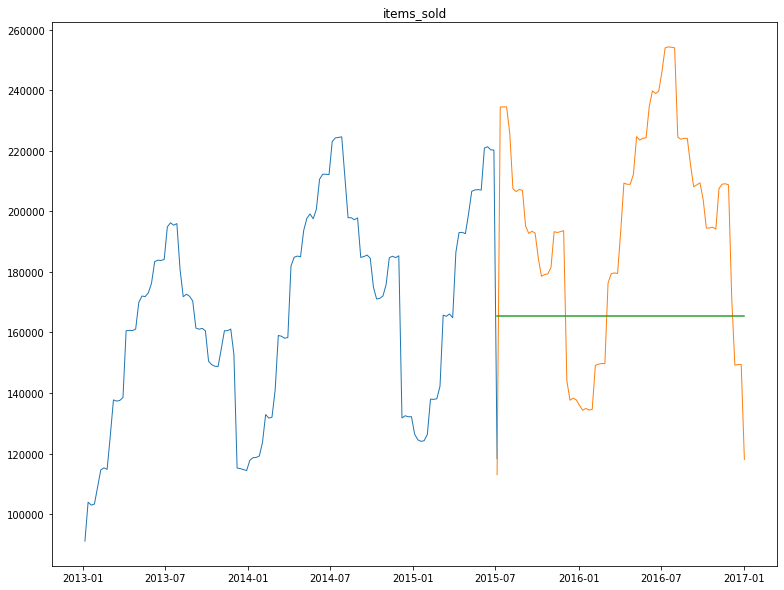

sales_total -- RMSE: 244426


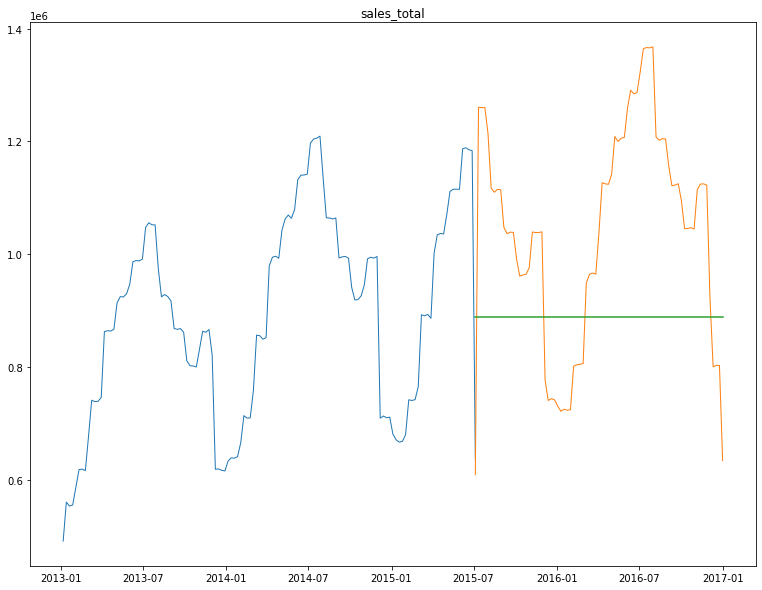

In [21]:
for col in train.columns:
    plot_and_evaluate(col)

## Create an evaluation df
- Will hold all RMSE for us to compare after we model with each type specified

In [22]:
eval_df = pd.DataFrame(columns = ['model_type', 'target_var', 'rmse'])

In [23]:
# function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    rmse = evaluate_rmse(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

In [24]:
for col in train.columns:
    eval_df = append_eval_df(model_type = "simple average", target_var = col)

In [25]:
eval_df.head()

,model_type,target_var,rmse
0,simple average,items_sold,45484.0
1,simple average,sales_total,244426.0


# Moving Average

In [26]:
period = 12

items = round(train["items_sold"].rolling(period).mean().iloc[-1],2)
dollars = round(train["sales_total"].rolling(period).mean().iloc[-1], 2)

In [27]:
yhat_df = make_predictions()
yhat_df.head()

,items_sold,sales_total
sale_date,,
2015-07-05 00:00:00+00:00,201141.58,1081556.78
2015-07-12 00:00:00+00:00,201141.58,1081556.78
2015-07-19 00:00:00+00:00,201141.58,1081556.78
2015-07-26 00:00:00+00:00,201141.58,1081556.78
2015-08-02 00:00:00+00:00,201141.58,1081556.78


## Plot Actual VS Predicted 

items_sold -- RMSE: 36361


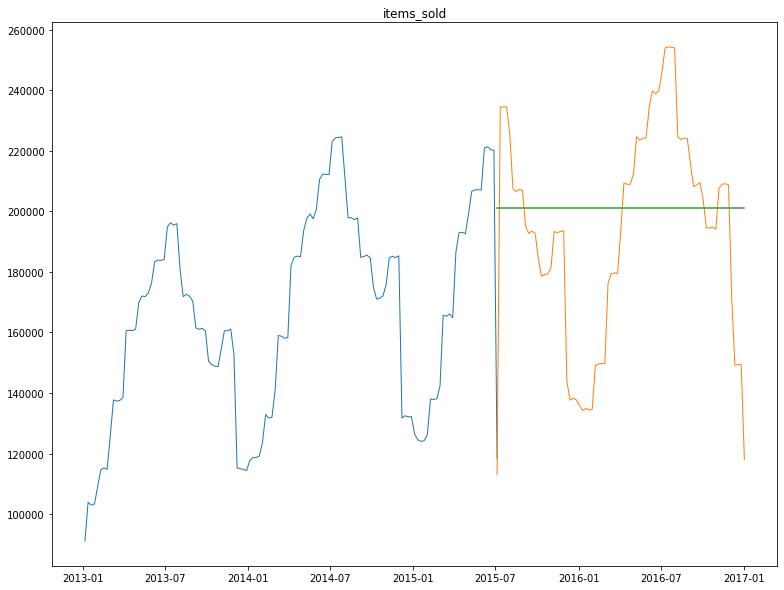

sales_total -- RMSE: 195470


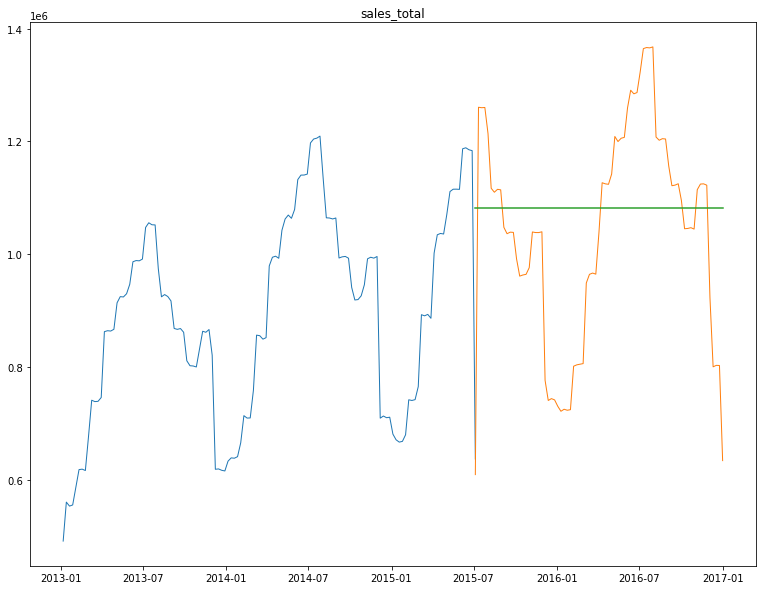

In [28]:
for col in train.columns:
    plot_and_evaluate(col)

In [29]:
for col in train.columns:
    eval_df = append_eval_df(model_type = '12 moving average', target_var = col)

In [30]:
eval_df.head()

,model_type,target_var,rmse
0,simple average,items_sold,45484.0
1,simple average,sales_total,244426.0
2,12 moving average,items_sold,36361.0
3,12 moving average,sales_total,195470.0


# Holt's Linear Trend Model

In [31]:
for col in train.columns:
    
    # make the thing
    model = Holt(train[col], exponential = False)
    
    # fit the thing
    model = model.fit(smoothing_level = .3, smoothing_slope = .1, optimized = False)
    
    # use the thing
    yhat_items = model.predict(start = validate.index[0], end = validate.index[-1])
    
    #add it to a df
    yhat_df[col] = round(yhat_items, 2)

In [32]:
yhat_df.head()

,items_sold,sales_total
sale_date,,
2015-07-05 00:00:00+00:00,228784.30,1229977.27
2015-07-12 00:00:00+00:00,195959.34,1053726.87
2015-07-19 00:00:00+00:00,196292.86,1055535.86
2015-07-26 00:00:00+00:00,196626.39,1057344.85
2015-08-02 00:00:00+00:00,196959.91,1059153.84


## Plot Actual VS Predicted

items_sold -- RMSE: 39312


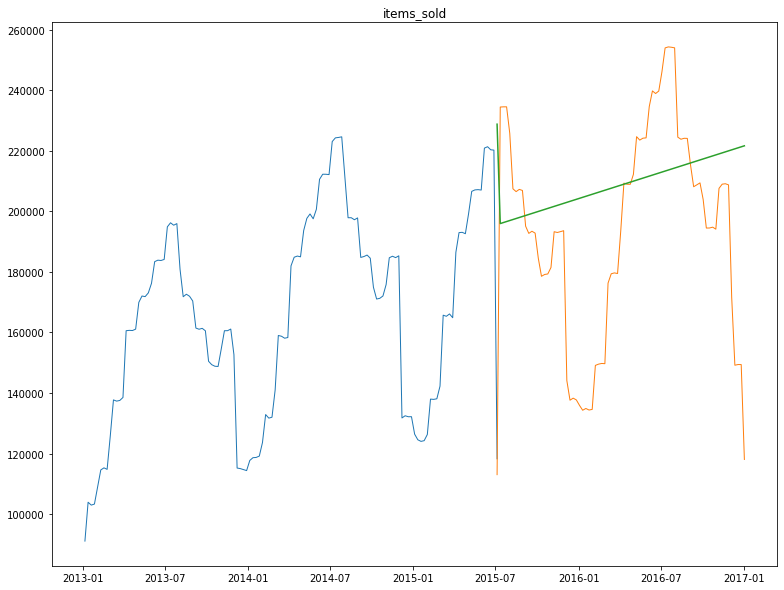

sales_total -- RMSE: 211664


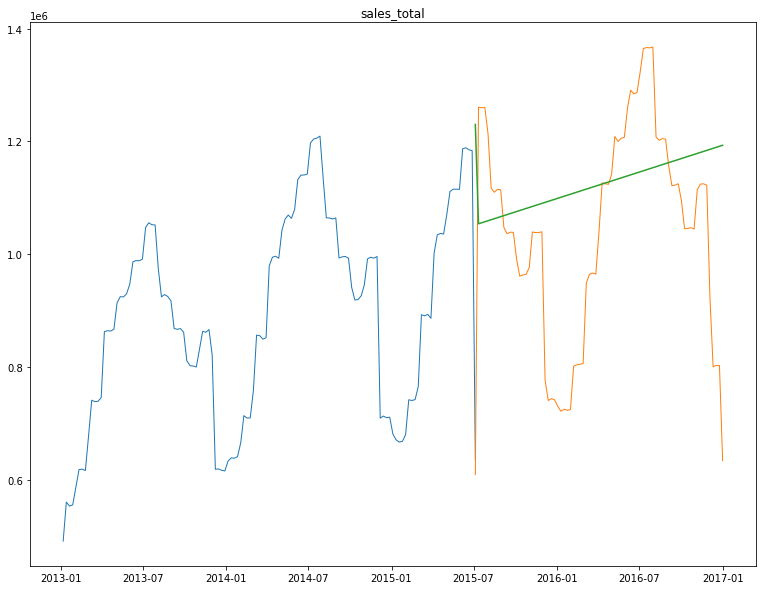

In [33]:
for col in train.columns:
    plot_and_evaluate(col)

## Evaluate
- add on to evaluate df for final evaluation after modeling

In [34]:
for col in train.columns:
    eval_df = append_eval_df(model_type = "Holts", target_var = col)

In [35]:
eval_df

,model_type,target_var,rmse
0,simple average,items_sold,45484.0
1,simple average,sales_total,244426.0
2,12 moving average,items_sold,36361.0
3,12 moving average,sales_total,195470.0
4,Holts,items_sold,39312.0
5,Holts,sales_total,211664.0


# Previous Cycle
- Based on previous year
- split original data by date instead of portions

In [36]:
df.head()

,items_sold,sales_total
sale_date,,
2013-01-06 00:00:00+00:00,91067.0,490767.50
2013-01-13 00:00:00+00:00,103902.0,559934.21
2013-01-20 00:00:00+00:00,102950.0,552813.52
2013-01-27 00:00:00+00:00,103298.0,554908.84
2013-02-03 00:00:00+00:00,109027.0,586547.55


In [37]:
df.tail()

,items_sold,sales_total
sale_date,,
2017-12-03 00:00:00+00:00,187286.0,1006145.15
2017-12-10 00:00:00+00:00,154400.0,830597.14
2017-12-17 00:00:00+00:00,155296.0,834271.29
2017-12-24 00:00:00+00:00,155482.0,836038.21
2017-12-31 00:00:00+00:00,155461.0,835025.61


In [38]:
train = df[:"2015"]
validate = df["2016"]
test = df["2017"]

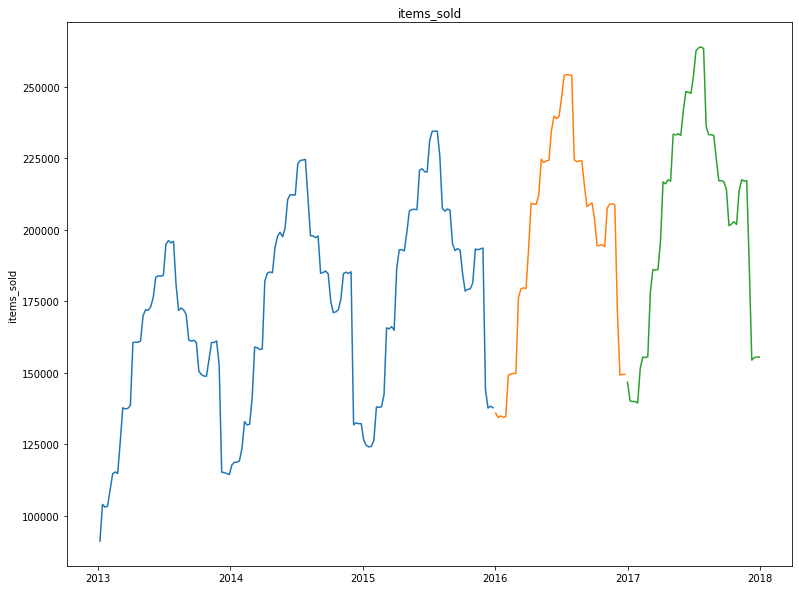

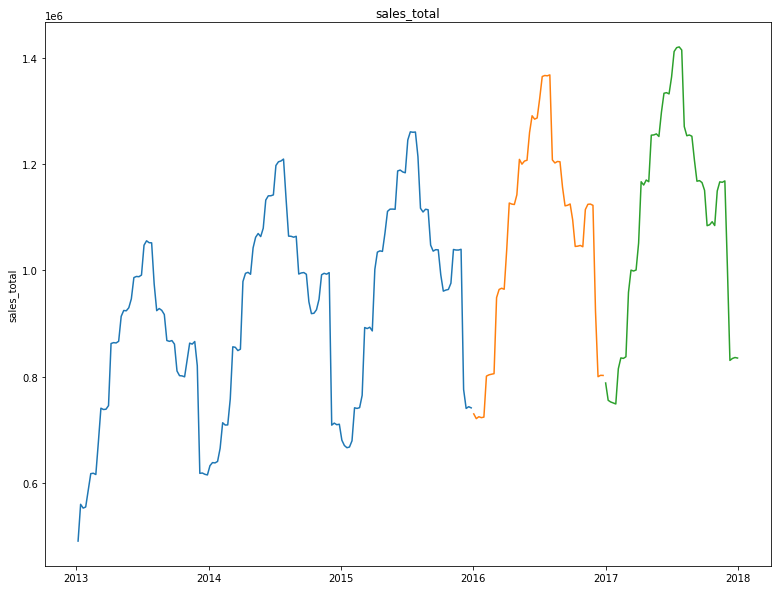

In [39]:
#Validate splits
for col in train.columns:
    plt.figure(figsize=(13,10))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show

## Make Predictions

In [40]:
yhat_df = train["2015"] + train.diff(52).mean()

In [41]:
yhat_df

,items_sold,sales_total
sale_date,,
2015-01-04 00:00:00+00:00,141777.375,7.633671e+05
2015-01-11 00:00:00+00:00,139935.375,7.533087e+05
2015-01-18 00:00:00+00:00,139406.375,7.491767e+05
2015-01-25 00:00:00+00:00,139640.375,7.504692e+05
2015-02-01 00:00:00+00:00,141683.375,7.622129e+05
2015-02-08 00:00:00+00:00,153372.375,8.242657e+05
2015-02-15 00:00:00+00:00,153281.375,8.230651e+05
2015-02-22 00:00:00+00:00,153475.375,8.245304e+05
2015-03-01 00:00:00+00:00,157660.375,8.477074e+05


In [42]:
yhat_df.index = validate.index

In [43]:
yhat_df

,items_sold,sales_total
sale_date,,
2016-01-03 00:00:00+00:00,141777.375,7.633671e+05
2016-01-10 00:00:00+00:00,139935.375,7.533087e+05
2016-01-17 00:00:00+00:00,139406.375,7.491767e+05
2016-01-24 00:00:00+00:00,139640.375,7.504692e+05
2016-01-31 00:00:00+00:00,141683.375,7.622129e+05
2016-02-07 00:00:00+00:00,153372.375,8.242657e+05
2016-02-14 00:00:00+00:00,153281.375,8.230651e+05
2016-02-21 00:00:00+00:00,153475.375,8.245304e+05
2016-02-28 00:00:00+00:00,157660.375,8.477074e+05


items_sold -- RMSE: 4187


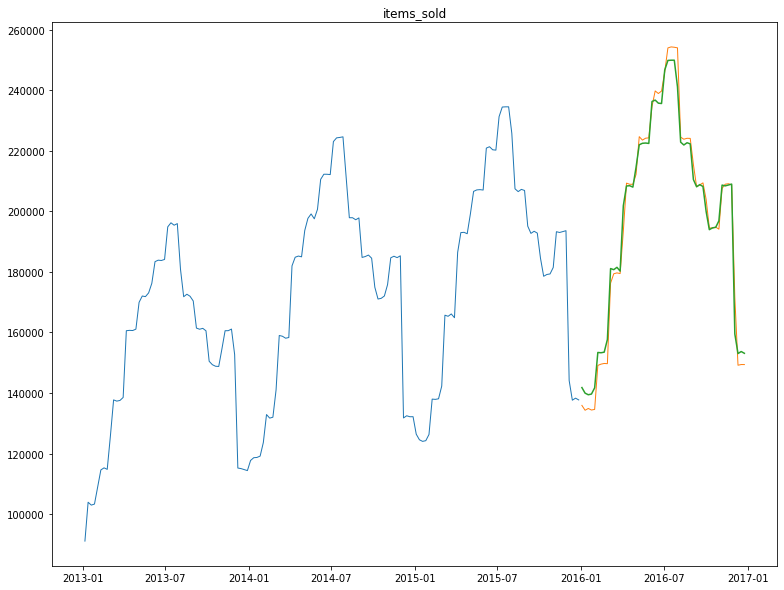

sales_total -- RMSE: 22730


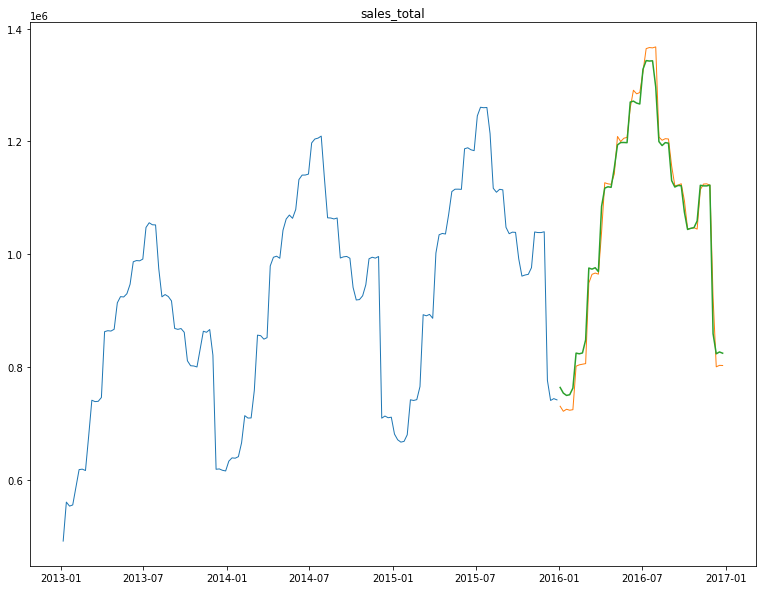

In [44]:
for col in train.columns:
    plot_and_evaluate(target_variable = col)
    eval_df = append_eval_df(model_type = 'previous year', target_var = col)

# Conclusion
- Which model did the best?

In [45]:
eval_df

,model_type,target_var,rmse
0,simple average,items_sold,45484.0
1,simple average,sales_total,244426.0
2,12 moving average,items_sold,36361.0
3,12 moving average,sales_total,195470.0
4,Holts,items_sold,39312.0
5,Holts,sales_total,211664.0
6,previous year,items_sold,4187.0
7,previous year,sales_total,22730.0


In [46]:
eval_df.groupby("target_var")['rmse'].min()[1]

22730.0

In [47]:
#get the min rmse for each variable from our eval_df
min_rmse_sales_total = eval_df.groupby("target_var")['rmse'].min()[1]
min_rmse_items_sold = eval_df.groupby("target_var")['rmse'].min()[0]

In [48]:
#filter by the mins
eval_df[((eval_df.rmse == min_rmse_sales_total) | 
         (eval_df.rmse == min_rmse_items_sold)
        )]

,model_type,target_var,rmse
6,previous year,items_sold,4187.0
7,previous year,sales_total,22730.0


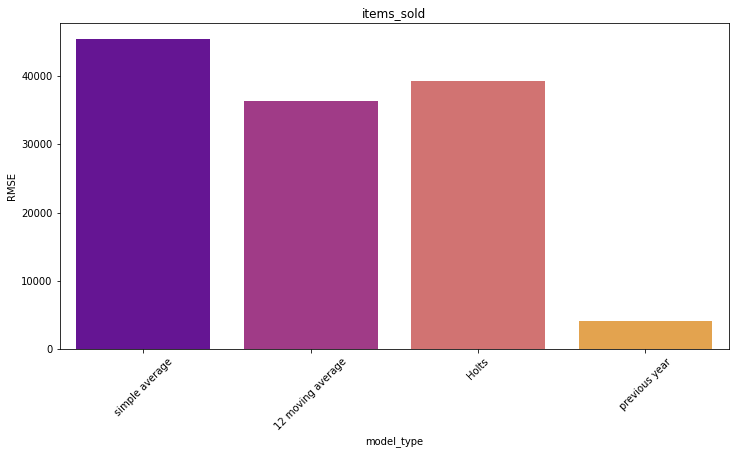

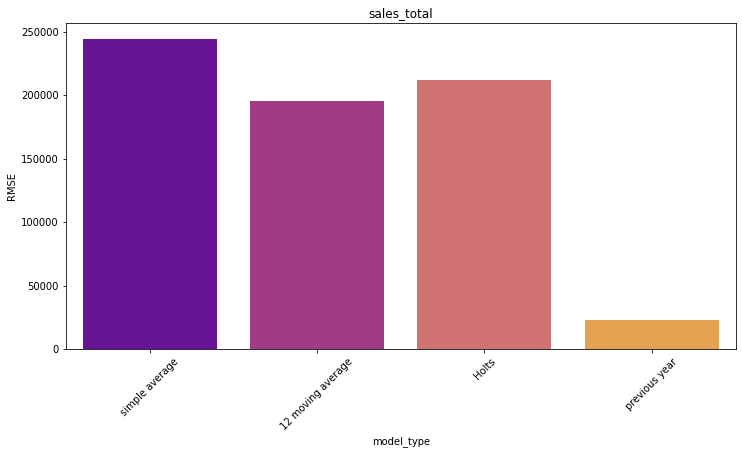

In [49]:

for col in train.columns:
    x = eval_df[eval_df.target_var == col]['model_type']
    y = eval_df[eval_df.target_var == col]['rmse']
    plt.figure(figsize=(12, 6))
    sns.barplot(x, y, palette="plasma")
    plt.title(col)
    plt.ylabel('RMSE')
    plt.xticks(rotation=45)
    plt.show()

# Test Model Performance

- Let's test it out on our out-of-sample data (the test df)

- We will be using train + validate to predict test.

In [51]:
train = df[:"2015"]
validate = df["2016"]
test = df["2017"]

In [54]:
test = test[test.index != "2017-01-01 00:00:00+00:00"]

In [57]:
yhat_df = validate + train.diff(52).mean()
yhat_df.index = test.index

In [58]:
rmse_dollars = round(sqrt(mean_squared_error(test["sales_total"], yhat_df["sales_total"])), 0)

rmse_items = round(sqrt(mean_squared_error(test["items_sold"], yhat_df["items_sold"])),0)

In [59]:
rmse_dollars

61684.0

In [60]:
rmse_items

11465.0

In [61]:
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(test[target_var], label = 'Test', linewidth = 1)
    plt.plot(yhat_df[target_var], alpha = .5)
    plt.title(target_var)
    plt.show()

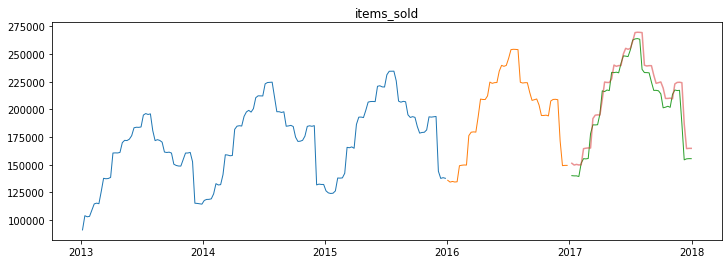

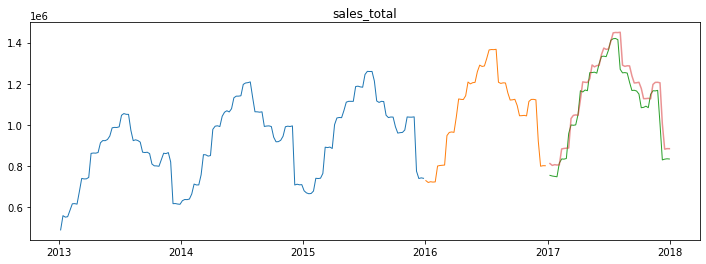

In [63]:
for col in train.columns:
    plot_and_eval(col)